## sentiment analysis - TFRF feature weighting with RNN classification

# Libraries

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #Count Vector Space Model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics #Matrix Builder
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import KFold #Import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
from textvec import vectorizers

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from keras.layers import Dense, Activation
from keras import Sequential
from keras.models import load_model

# Load Dataset

_`preprocessed dataset`_

In [2]:
df = pd.read_csv('D:\kuliah\THE ONLY TA THINGS\DATA\data clean\cleaned_15000_data_sample.csv')
df

,content,score,at,label,cleansing,case_folding,no_unwanted,tokenize,normalization,stopwords,stemming,clean
0,Keren,5,2023-04-14 19:21:43,1,Keren,keren,keren,['keren'],['keren'],['keren'],['keren'],keren
1,Woy tiktok menangis gw event mlbb creator base...,5,2023-04-07 23:01:39,1,Woy tiktok menangis gw event mlbb creator base...,woy tiktok menangis gw event mlbb creator base...,woy tiktok menangis gw event mlbb creator base...,"['woy', 'tiktok', 'menangis', 'gw', 'event', '...","['oi', 'tiktok', 'menangis', 'gue', 'event', '...","['tiktok', 'menangis', 'gue', 'event', 'mlbb',...","['tiktok', 'menang', 'gue', 'event', 'mlbb', '...",tiktok menang gue event mlbb creator base gue ...
2,Halo disini saya ingin menyampaikan kepada and...,4,2023-04-07 20:13:21,1,Halo disini saya ingin menyampaikan kepada and...,halo disini saya ingin menyampaikan kepada and...,halo disini saya ingin menyampaikan kepada and...,"['halo', 'disini', 'saya', 'ingin', 'menyampai...","['halo', 'di sini', 'saya', 'ingin', 'menyampa...","['di sini', 'membuka', 'komen', 'lag', 'koneks...","['di sini', 'buka', 'komen', 'lag', 'koneksi',...",di sini buka komen lag koneksi internet bagus ...
3,Jangan mau main tiktokla paket kuota cpt hbis ...,2,2023-04-11 17:06:47,-1,Jangan mau main tiktokla paket kuota cpt hbis ...,jangan mau main tiktokla paket kuota cpt hbis ...,jangan mau main tiktokla paket kuota cpt hbis ...,"['jangan', 'mau', 'main', 'tiktokla', 'paket',...","['jangan', 'mau', 'main', 'tiktokla', 'paket',...","['main', 'tiktokla', 'paket', 'kuota', 'cepat'...","['main', 'tiktokla', 'paket', 'kuota', 'cepat'...",main tiktokla paket kuota cepat habis potong k...
4,Sangat menghibur asyik dan seru,5,2023-04-13 21:08:45,1,Sangat menghibur asyik dan seru,sangat menghibur asyik dan seru,sangat menghibur asyik dan seru,"['sangat', 'menghibur', 'asyik', 'dan', 'seru']","['sangat', 'menghibur', 'asyik', 'dan', 'seru']","['menghibur', 'seru']","['hibur', 'seru']",hibur seru
...,...,...,...,...,...,...,...,...,...,...,...,...
7833,Bagus,5,2023-04-12 07:08:12,1,Bagus,bagus,bagus,['bagus'],['bagus'],['bagus'],['bagus'],bagus
7834,Sangat dramatis dan seru,5,2023-04-07 04:51:48,1,Sangat dramatis dan seru,sangat dramatis dan seru,sangat dramatis dan seru,"['sangat', 'dramatis', 'dan', 'seru']","['sangat', 'dramatis', 'dan', 'seru']","['dramatis', 'seru']","['dramatis', 'seru']",dramatis seru
7835,Baik buat mata +18,5,2023-04-09 10:05:38,1,Baik buat mata,baik buat mata,baik buat mata,"['baik', 'buat', 'mata']","['baik', 'buat', 'mata']",[],[],NaN
7836,min ini gimana gabisa masuk min 😦😦,1,2023-04-10 18:09:14,-1,min ini gimana gabisa masuk min,min ini gimana gabisa masuk min,min ini gimana gabisa masuk min,"['min', 'ini', 'gimana', 'gabisa', 'masuk', 'm...","['min', 'ini', 'bagaimana', 'enggak bisa', 'ma...",['enggak bisa'],['enggak bisa'],enggak bisa


In [3]:
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.isnull().sum()

content          0
score            0
at               0
label            0
cleansing        0
case_folding     0
no_unwanted      0
tokenize         0
normalization    0
stopwords        0
stemming         0
clean            0
dtype: int64

_`total label value`_

In [5]:
df['label'].value_counts()

label
 1    5738
-1    1118
 0     329
Name: count, dtype: int64

# TFIDF for feature weighting

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['stemming'], df['label'], test_size=0.2, random_state=42)


In [7]:
vectorizer = CountVectorizer(strip_accents='unicode',token_pattern=r'\w{1,}',ngram_range=(1, 1)).fit(X_train)
tfrf_vec = vectorizers.TfrfVectorizer(sublinear_tf=True)
tfrf_vec.fit(vectorizer.transform(X_train), y_train)
TFRF_train = tfrf_vec.transform(vectorizer.transform(X_train))
TFRF_train = TFRF_train.toarray()

In [8]:
vectorizer = CountVectorizer(strip_accents='unicode',token_pattern=r'\w{1,}',ngram_range=(1, 1)).fit(X_test)
tfrf_vec = vectorizers.TfrfVectorizer(sublinear_tf=True)
tfrf_vec.fit(vectorizer.transform(X_test), y_test)
TFRF_test = tfrf_vec.transform(vectorizer.transform(X_test))
TFRF_test = TFRF_test.toarray()

In [9]:
from keras_preprocessing.sequence import pad_sequences
maxlen = 121 # set the maximum sequence length to 121
TFRF_train = pad_sequences(TFRF_train, maxlen=maxlen)
TFRF_test = pad_sequences(TFRF_test, maxlen=maxlen)

In [10]:
TFRF_train.shape

(5748, 121)

In [11]:
TFRF_test.shape


(1437, 121)

#### split data test data train

_`Seperate label to its own array`_

In [12]:
label = []
for data in df['label']:
    label.append(data)
kolom = label.pop

In [13]:
print(label)

[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 0, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 0, 1, 1, 1, 1, -1, 1, 1, 1, 0, -1, 1, 1, 1, 1, -1, 1, 1, 0, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 0, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 0, 1, 1, 1, 1, -1, 0, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1

## Define RNN Model

In [14]:
def build_model(input_dim):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(input_dim, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Implement w/ k-fold

In [15]:
# Train and evaluate the RNN model using k-fold cross-validation
folds = range(2,3)

for k in folds:
    scores = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(TFRF_train):
        X_train_fold, X_val_fold = TFRF_train[train_index], TFRF_train[val_index]
        y_train = np.array(label)
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        model = build_model(input_dim=TFRF_train.shape[1])
        model.fit(np.expand_dims(X_train_fold, axis=2), y_train_fold, batch_size=64, epochs=5, verbose=0)
        
        loss, accuracy = model.evaluate(np.expand_dims(X_val_fold, axis=2), y_val_fold, verbose=0)
        scores.append(accuracy)

    # print('Cross-validation accuracy (k={0}):'.format(k), np.mean(scores))

    print('Folds : %d | Cross-validation accuracy : %.4f | Max, Min : %.4f, %.4f' 
            % (k, np.mean(scores), max(scores), min(scores)))
    print("\n")    

Folds : 2 | Cross-validation accuracy : 0.7999 | Max, Min : 0.8034, 0.7965




## Evaluate the RNN model on the test set

In [16]:
loss_test, accuracy_test = model.evaluate(np.expand_dims(TFRF_test, axis=2), y_test, verbose=0)
print('Test accuracy:', accuracy_test)

Test accuracy: 0.7870563864707947


In [17]:
y_pred_test = np.round(model.predict(np.expand_dims(TFRF_test, axis=2)))
print('Confusion matrix:')
conf_matrix = confusion_matrix(y_test, y_pred_test)
print(conf_matrix)
# class_names = ['negative', 'neutral', 'positive']
# print('Classification report:')
# print(classification_report(y_test, y_pred_test, target_names=class_names))
# print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


45/45 [==============================] - 2s 37ms/step
Confusion matrix:
[[   0    0  240]
 [   0    0   66]
 [   0    0 1131]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       240
           0       0.00      0.00      0.00        66
           1       0.79      1.00      0.88      1131

    accuracy                           0.79      1437
   macro avg       0.26      0.33      0.29      1437
weighted avg       0.62      0.79      0.69      1437



c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Madluke\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

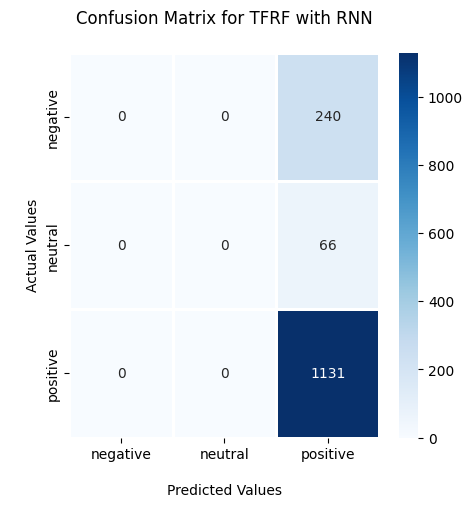

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize = (5, 5))
ax = sns.heatmap(conf_matrix, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['negative', 'neutral', 'positive'],
                    yticklabels = ['negative', 'neutral', 'positive'])
ax.set_title("Confusion Matrix for TFRF with RNN\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("\nActual Values")
plt.show()